In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data=pd.read_csv("./digital recongnizer/train.csv")

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X=data.iloc[:,1:]

In [7]:
X.shape

(42000, 784)

In [8]:
y=data.iloc[:,0]

In [9]:
y.shape

(42000,)

## 方差过滤器

In [10]:
from sklearn.feature_selection import VarianceThreshold
#方差过滤器

In [12]:
selector=VarianceThreshold()#实例化不填参数默认方差为0

In [13]:
X_var0 =selector.fit_transform(X)#删除方差为0的序列

In [14]:
X_var0.shape

(42000, 708)

In [24]:
#删除中位数以下的特征
x_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)

In [22]:
X.var()#所有列的方差

pixel0      0.000000
pixel1      0.000000
pixel2      0.000000
pixel3      0.000000
pixel4      0.000000
              ...   
pixel779    0.171615
pixel780    0.000000
pixel781    0.000000
pixel782    0.000000
pixel783    0.000000
Length: 784, dtype: float64

In [23]:
np.median(X.var().values)#所有列方差的中位数

1352.286703180131

In [26]:
x_fsvar.shape#392个特征

(42000, 392)

In [27]:
#若特征是伯努利随机变量，假设p=0.8，即二分类特征中某种分类占到80%以上的时候删除特征
X_bvar = VarianceThreshold(.8 * (1 - .8)).fit_transform(X)
X_bvar.shape

(42000, 685)

## 方差过滤器

In [11]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [31]:
#假设在这里我一直我需要300个特征
X_fschi = SelectKBest(chi2, k=300).fit_transform(x_fsvar, y)
X_fschi.shape

(42000, 300)

In [32]:
cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9344761904761905

In [36]:
x_fsvar.shape

(42000, 392)

ValueError: x and y must have same first dimension, but have shapes (15,) and (19,)

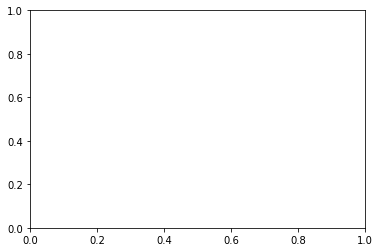

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
score = []
for i in range(390,200,-10):
    X_fschi = SelectKBest(chi2, k=i).fit_transform(x_fsvar, y)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()
    score.append(once)


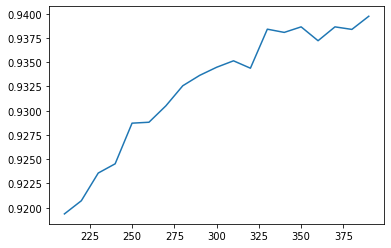

In [38]:
plt.plot(range(390,200,-10),score)
plt.show()

In [40]:
chivalue, pvalues_chi = chi2(x_fsvar,y)
#chivalue每个数据的卡方值，pvalues_chi每个数据对应的p值

In [42]:
chivalue.shape

(392,)

In [67]:
pvalues_chi.shape

(392,)

In [51]:
#k取多少？我们想要消除所有p值大于设定值，比如0.05或0.01的特征：
(pvalues_chi > 0.05).sum()

0

In [52]:
k = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
#X_fschi = SelectKBest(chi2, k=填写具体的k).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

In [53]:
k

392

## F检验

In [12]:
from sklearn.feature_selection import f_classif
#f检验分类

In [55]:
F,pvalues_f = f_classif(x_fsvar,y)

In [57]:
F.shape

(392,)

In [59]:
pvalues_f.shape

(392,)

In [61]:
k = F.shape[0] - (pvalues_f > 0.05).sum()

#X_fsF = SelectKBest(f_classif, k=填写具体的k).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fsF,y,cv=5).mean()

In [62]:
k

392

In [68]:
#得到的结论和我们用卡方过滤得到的结论一模一样：没有任何特征的p值大于0.01，所有的特征都是和标签相关
#的，因此我们不需要相关性过滤。

##  互信息法

In [13]:
from sklearn.feature_selection import mutual_info_classif as MIC

In [73]:
result = MIC(x_fsvar,y)

In [75]:
result.shape

(392,)

In [76]:
sum(result <= 0)

0

In [77]:
k = result.shape[0] - sum(result <= 0)
#X_fsmic = SelectKBest(MIC, k=填写具体的k).fit_transform(X_fsvar, y)
#cross_val_score(RFC(n_estimators=10,random_state=0),X_fsmic,y,cv=5).mean()

In [78]:
k

392

## 嵌入法

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC

In [30]:
RFC_ = RFC(n_estimators =10,random_state=0)#随机森林实例化

In [31]:
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y)
#特征重要性的阈值，重要性低于这个阈值的特征都将被删除

In [32]:
X_embedded

array([[  0,   0,   0, ..., 253,   0,   0],
       [254, 254, 254, ..., 254, 255, 254],
       [  9, 254, 254, ...,   0, 254, 254],
       ...,
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,  27, ..., 242,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int64)

In [33]:
X_embedded.shape

(42000, 47)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
RFC_.fit(X,y).feature_importances_.shape

(784,)

In [35]:
(RFC_.fit(X,y).feature_importances_).max()

0.01276360214820271

In [36]:
threshold=np.linspace(0,(RFC_.fit(X,y).feature_importances_).max(),20)

In [37]:
threshold

array([0.        , 0.00067177, 0.00134354, 0.00201531, 0.00268707,
       0.00335884, 0.00403061, 0.00470238, 0.00537415, 0.00604592,
       0.00671769, 0.00738945, 0.00806122, 0.00873299, 0.00940476,
       0.01007653, 0.0107483 , 0.01142007, 0.01209183, 0.0127636 ])

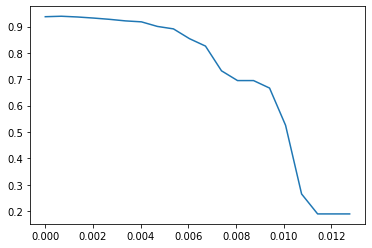

In [92]:
score=[]
for i in threshold:
    X_embedded=SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once=cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score.append(once)
plt.plot(threshold,score)
plt.show()

In [38]:
X_embedded=SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
X_embedded.shape
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9391190476190475

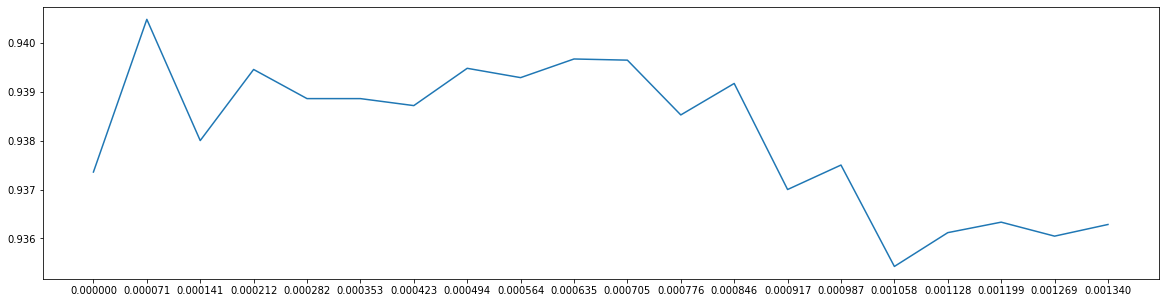

In [95]:
#和其他调参一样，我们可以在第一条学习曲线后选定一个范围，使用细化的学习曲线来找到最佳值：
score2 = []
for i in np.linspace(0,0.00134,20):
    X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
    once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
    score2.append(once)
plt.figure(figsize=[20,5])
plt.plot(np.linspace(0,0.00134,20),score2)
plt.xticks(np.linspace(0,0.00134,20))
plt.show()

查看结果，果然0.00067并不是最高点，真正的最高点0.000564已经将模型效果提升到了94%以上。我们使用
0.000564来跑一跑我们的SelectFromModel:

In [39]:
X_embedded = SelectFromModel(RFC_,threshold=0.000564).fit_transform(X,y)
X_embedded.shape
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9392857142857144

In [40]:
#随机森林
cross_val_score(RFC(n_estimators=100,random_state=0),X_embedded,y,cv=5).mean()

0.9634285714285715

## 包装法

In [22]:
from sklearn.feature_selection import RFE

In [41]:
RFC_=RFC(n_estimators=10,random_state=0)

In [42]:
selector=RFE(RFC_,n_features_to_select=240,step=50).fit(X,y)

In [43]:
selector.support_.sum()

240

In [44]:
selector.ranking_

array([12, 11, 10,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  8,  8,
        7,  8,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  7,  6,
        6,  7,  5,  6,  6,  6,  7,  6,  7,  9,  8,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10,  8,  9,  6,  5,  3,  4,  5,  5,  2,  1,  2,  2,
        1,  5,  5,  6,  7,  7,  7, 10, 10, 11, 11, 11, 11, 10, 11, 11,  6,
        6,  5,  4,  3,  3,  3,  2,  2,  2,  2,  2,  3,  3,  4,  5,  5,  6,
        7,  7, 11, 11, 12, 12, 12, 12,  9,  6,  6,  5,  4,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  4,  5,  5,  7, 10, 12, 12, 12,
       12, 11,  6,  6,  5,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  3,  2,  2,  4,  5,  6, 12, 12, 12, 12, 11,  9,  6,  5,  4,  4,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  2,  2,  4,
        6,  6, 12, 11, 12

In [45]:
X_wrapper = selector.transform(X)


In [46]:
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()


0.9382857142857143

In [ ]:
score = []
for i in range(1,751,50):
    X_wrapper = RFE(RFC_,n_features_to_select=i, step=50).fit_transform(X,y)
    once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,751,50),score)
plt.xticks(range(1,751,50))
plt.show()